NCAR - Microphysics Team

### How dreary are the models?

### Function imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import uxarray as ux
import intake
import healpix as hp
import holoviews as hv

import easygems.healpix as egh
import easygems.remap as egr
from easygems.healpix import attach_coords

import easygems.healpix as eghp

import cmocean
import geoviews.feature as gf

### (Optional) Using Dask to parallize tasks

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

rda_scratch = '/glade/derecho/scratch/khirata/'

cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 32,
    memory = '1024GiB',
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=32:mem=256GB',
    queue = 'casper',
    walltime = '7:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

# cluster.scale(5)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.122:33221,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/khirata/hackathon-casper/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-21431' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/distributed/client.py:2371> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/distributed/client.py", line 2380, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-118908' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/distributed/client.py:2371> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/distributed/client.py", line 2380, in wait
    raise AllExit()
distributed.client.All

### Define the catalog

In [3]:
node_id = 'NCAR'
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[node_id]

### Define the zoom level

In [8]:
time_slice = slice("2019-01-01", "2021-03-01")
time_slice_icon = slice("2020-03-01", "2021-03-01")

In [5]:
zoom_lev = 8

### Plots for testing and debugging

In [6]:
# test_toggle = True
test_toggle = False

diurnal = False

### Read in data into UxArray (precipitation)

In [9]:
scl_icon = 86400. #kg/m2/s to mm/day
ds_icon = cat['icon_d3hp003'](zoom=zoom_lev).to_dask()
uxds_icon = ux.UxDataset.from_healpix(ds_icon)
uxda_pr_icon = uxds_icon['pr'].sel(time=time_slice_icon) #time_slice) #*scl_icon # mm/day

scl_scream = 86400.*1000. #m/s to mm/day
ds_scream = cat['scream2D_hrly'](zoom=zoom_lev).to_dask()
uxds_scream = ux.UxDataset.from_healpix(ds_scream)
uxda_pr_scream = uxds_scream['pr'].sel(time=time_slice) #*scl_scream # mm/day

scl_nicam = 86400. #kg/m2/s to mm/day
ds_nicam = cat['nicam_gl11'](zoom=zoom_lev, time='PT3H').to_dask()
uxds_nicam = ux.UxDataset.from_healpix(ds_nicam)
uxds_nicam.assign_coords(hour=uxds_nicam.time.dt.hour)
uxds_nicam.assign_coords(month=uxds_nicam.time.dt.month)
uxda_pr_nicam = uxds_nicam['pr'].sel(time=time_slice) #*scl_nicam # mm/day

scl_mpas = 48. #mm/30min to mm/day
ds_mpas = cat['mpas_dyamond3'](zoom=zoom_lev, time='PT30M').to_dask()
uxds_mpas = ux.UxDataset.from_healpix(ds_mpas)
uxda_pr_mpas = uxds_mpas['rainnc'].sel(time=time_slice) #*scl_nicam # mm/day


# scl_imerg = 24. #mm/hr to mm/day
# uxds_imerg = ux.UxDataset.from_healpix('/glade/derecho/scratch/andrew/hackathon/IMERG_V07B_hp9.zarr')
# scl_imerg = 24. #mm/hr to mm/day
# ds_imerg = cat['IR_IMERG'](zoom=9).to_dask()
# uxds_imerg = ux.UxDataset.from_healpix(ds_imerg)

# uxda_pr_imerg_fine = uxds_imerg['precipitation'].sel(time=time_slice)
# uxda_pr_imerg_fine = uxda_pr_imerg_fine.chunk({'time': 48, 'n_face': uxda_pr_imerg_fine.sizes['n_face']})

# level_down = 9 - zoom_lev
# uxda_pr_imerg_tmp = uxda_pr_imerg_fine
# for i in range(level_down):
#     uxda_pr_imerg_tmp = uxda_pr_imerg_tmp.coarsen(n_face=4).mean()
#     uxda_pr_imerg_tmp['crs'].attrs['healpix_nside'] = 2**int(9 - i - 1)
# uxda_pr_imerg = uxda_pr_imerg_tmp

# # level_down = 9 - zoom_lev
# # for i in range(level_down):
# #     uxds_imerg = uxds_imerg.coarsen(n_face=4).mean()
# #     uxds_imerg['crs'].attrs['healpix_nside'] = 2**int(9 - i - 1) #hp_nside // 2
# # uxda_rlut_imerg_rename = uxds_imerg.rename({'n_face': 'cell'})
# # uxds_imerg = ux.UxDataset.from_healpix(uxda_rlut_imerg_rename)

# # uxda_pr_imerg_orig = uxds_imerg['precipitation'].sel(time=time_slice)
# # uxda_pr_imerg_orig = uxda_pr_imerg_orig.chunk({'time': 48, 'n_face': uxda_pr_imerg_orig.sizes['n_face']})
# uxda_pr_imerg = uxda_pr_imerg.resample(time='1H').first().compute() #*scl_imerg # mm/day


/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of

In [11]:
month = 2 # February !!

threshold = 1 # mm/day

### Note: time interval is likely inconsistent 
uxda_pr_scream_3h = uxda_pr_scream.resample(time='3H').mean() #*scl_scream # mm/day
frequency_scream = (uxda_pr_scream_3h > threshold / scl_scream).groupby("time.month").mean("time").persist()
# frequency_scream = (uxda_pr_scream > threshold / scl_scream).groupby("time.month").mean("time").persist()


# uxda_pr_icon_3h = uxda_pr_icon.resample(time='3H').mean() #*scl_scream # mm/day
# frequency_icon = (uxda_pr_icon_3h > threshold / scl_icon).groupby("time.month").mean("time").persist()
frequency_icon = (uxda_pr_icon > threshold / scl_icon).groupby("time.month").mean("time").persist()

# uxda_pr_nicam_3h = uxda_pr_nicam.resample(time='3H').mean() #*scl_nicam # mm/day
# frequency_nicam = (uxda_pr_nicam_3h > threshold / scl_nicam).groupby("time.month").mean("time").persist()
frequency_nicam = (uxda_pr_nicam > threshold / scl_nicam).groupby("time.month").mean("time").persist()

# frequency_scream = (uxda_pr_scream > threshold / scl_scream).groupby("time.month").mean("time").sel(month=month).compute()
# frequency_icon = (uxda_pr_icon > threshold / scl_icon).groupby("time.month").mean("time").sel(month=month).compute()
# frequency_nicam = (uxda_pr_nicam > threshold / scl_nicam).groupby("time.month").mean("time").sel(month=month).compute()
# frequency_imerg = (uxda_pr_imerg > threshold / scl_imerg).groupby("time.month").mean("time").sel(month=month).compute()

<string>:7: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.


In [13]:
uxda_pr_mpas_diff = uxda_pr_mpas.diff(dim="time", label="lower")
uxda_pr_mpas_diff_3h = uxda_pr_mpas_diff.resample(time='3H').mean().persist() #*scl_nicam # mm/day
frequency_mpas = (uxda_pr_mpas_diff_3h > threshold / scl_mpas).groupby("time.month").mean("time").persist()
# frequency_mpas = (uxda_pr_mpas_diff * scl_mpas > threshold).groupby("time.month").mean("time").sel(month=month).compute()

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/xarray/groupers.py:498: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


In [14]:
rda_scratch = '/glade/derecho/scratch/khirata/'

frequency_scream.to_netcdf(rda_scratch + 'frequency_gt_1mm_scream_pt3h.nc')
frequency_icon.to_netcdf(rda_scratch + 'frequency_gt_1mm_icon_pt3h.nc')
frequency_nicam.to_netcdf(rda_scratch + 'frequency_gt_1mm_nicam_pt3h.nc')
frequency_mpas.to_netcdf(rda_scratch + 'frequency_gt_1mm_mpas_pt3h.nc')
# frequency_scream.to_netcdf(rda_scratch + 'frequency_gt_1mm_scream.nc')
# frequency_icon.to_netcdf(rda_scratch + 'frequency_gt_1mm_icon.nc')
# frequency_nicam.to_netcdf(rda_scratch + 'frequency_gt_1mm_nicam.nc')
# frequency_mpas.to_netcdf(rda_scratch + 'frequency_gt_1mm_mpas.nc')

KeyboardInterrupt: 

In [11]:
def read_nc_freq(fn_nc, varname='pr'):
    uxds_freq_f = xr.open_dataset(fn_nc)
    frequency_f_tmp = uxds_freq_f[varname].compute()
    frequency_f_tmp = frequency_f_tmp.astype('float64')
    ds = frequency_f_tmp.to_dataset()
    ds = ds.swap_dims({'n_face': 'cell'})
    frequency_from_file = ux.UxDataset.from_healpix(ds)[varname]
    return frequency_from_file

In [ ]:
# Load the NetCDF file
rda_scratch = '/glade/derecho/scratch/khirata/'

frequency_um_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_um_v2.nc', 'pr')
# frequency_scream_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_scream.nc', 'pr')
# frequency_icon_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_icon.nc', 'pr')
# frequency_nicam_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_nicam.nc', 'pr')
# frequency_mpas_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_mpas.nc', 'rainnc')
frequency_scream_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_scream_pt3h.nc', 'pr')
frequency_icon_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_icon_pt3h.nc', 'pr')
frequency_nicam_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_nicam_pt3h.nc', 'pr')
frequency_mpas_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_mpas_pt3h.nc', 'rainnc')
frequency_cas_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_cas_MAYBE.nc', 'pr')
# frequency_imerg_from_file = read_nc_freq(rda_scratch + 'IR_IMERG_mo_freq_2020.nc', 'precipitation')
frequency_imerg_from_file = read_nc_freq(rda_scratch + 'frequency_gt_1mm_imerg_test.nc', 'precipitation')


### Old
# uxds_freq_um = xr.open_dataset(rda_scratch + 'frequency_gt_1mm_um.nc') # change the path if needed!!
# frequency_um_tmp = uxds_freq_um['pr'].compute()
# frequency_um_tmp = frequency_um_tmp.astype('float64')
# ds = frequency_um_tmp.to_dataset()
# ds = ds.swap_dims({'n_face': 'cell'})
# frequency_um_from_file = ux.UxDataset.from_healpix(ds)['pr']

Text(0.5, 0.98, 'Precipitation Frequency (month=2)')

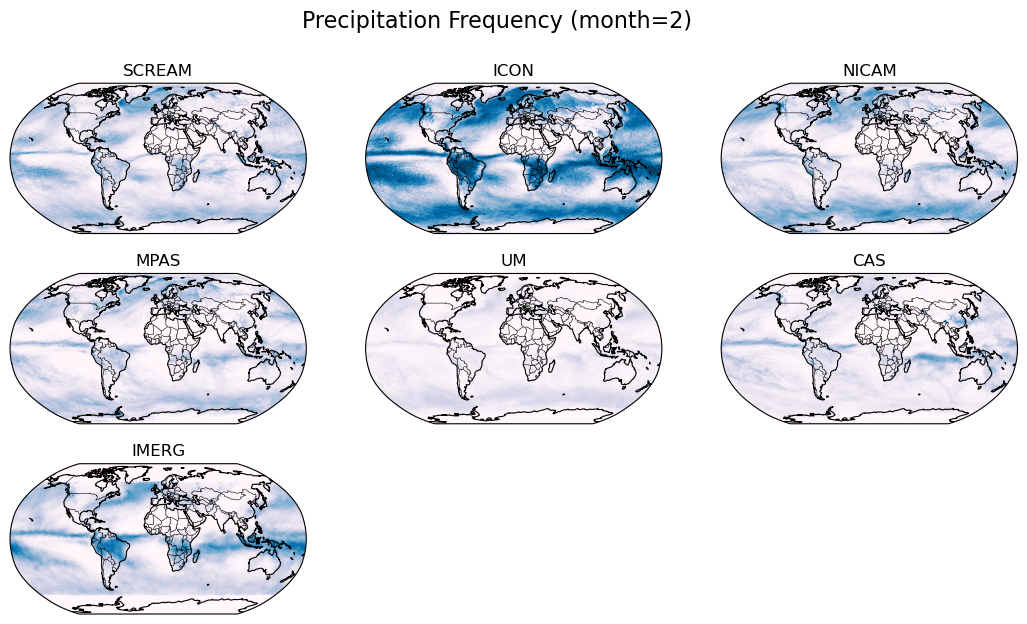

In [28]:
%matplotlib inline

month = 2

# pr_freq_scream = (uxda_pr_scream > threshold).groupby("time.month").mean("time")
# pr_freq_icon   = (uxda_pr_icon > threshold).groupby("time.month").mean("time")
# pr_freq_nicam  = (uxda_pr_nicam > threshold).groupby("time.month").mean("time")
# pr_freq_imerg  = (uxda_pr_imerg > threshold).groupby("time.month").mean("time")

# fig, axes = plt.subplots(3, 3, figsize=(13, 7), subplot_kw={'projection': ccrs.Robinson()})
fig = plt.figure(figsize=(13, 7))

ax1 = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson())
ax1.set_global()
ax1.set_title("SCREAM")
mappable = eghp.healpix_show(frequency_scream_from_file.sel(month=month), ax=ax1, cmap="PuBu", vmin=0, vmax=1)
ax1.add_feature(cf.COASTLINE, linewidth=0.8)
ax1.add_feature(cf.BORDERS, linewidth=0.4)

ax2 = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson())
ax2.set_global()
ax2.set_title("ICON")
mappable = eghp.healpix_show(frequency_icon_from_file.sel(month=month), ax=ax2, cmap="PuBu", vmin=0, vmax=1)
ax2.add_feature(cf.COASTLINE, linewidth=0.8)
ax2.add_feature(cf.BORDERS, linewidth=0.4)

ax3 = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson())
ax3.set_global()
ax3.set_title("NICAM")
mappable = eghp.healpix_show(frequency_nicam_from_file.sel(month=month), ax=ax3, cmap="PuBu", vmin=0, vmax=1)
ax3.add_feature(cf.COASTLINE, linewidth=0.8)
ax3.add_feature(cf.BORDERS, linewidth=0.4)

ax4 = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson())
ax4.set_global()
ax4.set_title("MPAS")
mappable = eghp.healpix_show(frequency_mpas_from_file.sel(month=month), ax=ax4, cmap="PuBu", vmin=0, vmax=1)
ax4.add_feature(cf.COASTLINE, linewidth=0.8)
ax4.add_feature(cf.BORDERS, linewidth=0.4)


ax5 = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson())
ax5.set_global()
ax5.set_title("UM")
mappable = eghp.healpix_show(frequency_um_from_file.sel(month=month), ax=ax5, cmap="PuBu", vmin=0, vmax=1)
ax5.add_feature(cf.COASTLINE, linewidth=0.8)
ax5.add_feature(cf.BORDERS, linewidth=0.4)

ax6 = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson())
ax6.set_global()
ax6.set_title("CAS")
mappable = eghp.healpix_show(frequency_cas_from_file.sel(month=month), ax=ax6, cmap="PuBu", vmin=0, vmax=1)
ax6.add_feature(cf.COASTLINE, linewidth=0.8)
ax6.add_feature(cf.BORDERS, linewidth=0.4)

ax7 = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson())
ax7.set_global()
ax7.set_title("IMERG")
mappable = eghp.healpix_show(frequency_imerg_from_file.sel(month=month), ax=ax7, cmap="PuBu", vmin=0, vmax=1)
ax7.add_feature(cf.COASTLINE, linewidth=0.8)
ax7.add_feature(cf.BORDERS, linewidth=0.4)

fig.colorbar(
    mappable, ax=axes[:, :], orientation='horizontal', shrink=0.7, pad=0.05,
    label="Precipitation Frequency (>1 mm)"
)

fig.suptitle(f"Precipitation Frequency (month={month})", fontsize=16)


# fig.colorbar(
#     mappable_imerg, ax=axes[1, 1], orientation='horizontal', shrink=0.7, pad=0.05,
    # label="Precipitation Frequency Difference"
# )
# plt.tight_layout()

In [24]:
month = 2

frequency_zm_scream   = frequency_scream_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_icon     = frequency_icon_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_nicam    = frequency_nicam_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_um       = frequency_um_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_mpas     = frequency_mpas_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_cas      = frequency_cas_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))
frequency_zm_imerg    = frequency_imerg_from_file.sel(month=month).zonal_mean(lat=(-85, 86, 5))

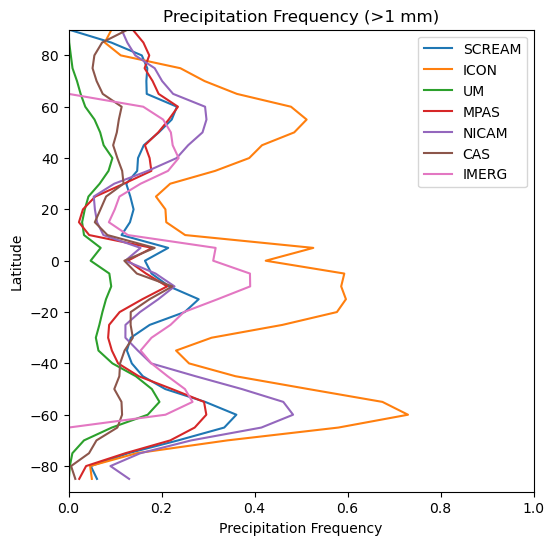

In [23]:

# frequency_zm_icon   = frequency_icon.zonal_mean(lat=(-85, 86, 5))
# frequency_zm_nicam  = frequency_nicam.zonal_mean(lat=(-85, 86, 5))
# frequency_zm_mpas   = frequency_mpas.zonal_mean(lat=(-85, 86, 5))
# frequency_zm_mpas   = frequency_mpas.zonal_mean(lat=(-85, 86, 5))

plt.figure(figsize=(6, 6))

plt.plot(frequency_zm_scream, frequency_zm_scream.latitudes, label="SCREAM")
plt.plot(frequency_zm_icon, frequency_zm_icon.latitudes, label="ICON")
plt.plot(frequency_zm_um, frequency_zm_um.latitudes, label="UM")
plt.plot(frequency_zm_mpas, frequency_zm_mpas.latitudes, label="MPAS")
plt.plot(frequency_zm_nicam, frequency_zm_nicam.latitudes, label="NICAM")
plt.plot(frequency_zm_cas, frequency_zm_cas.latitudes, label="CAS")
plt.plot(frequency_zm_imerg, frequency_zm_imerg.latitudes, label="IMERG")

plt.xlim(0, 1)
plt.ylim(-90, 90)

plt.xlabel("Precipitation Frequency")
plt.ylabel("Latitude")
plt.title("Precipitation Frequency (>1 mm)")
plt.legend()


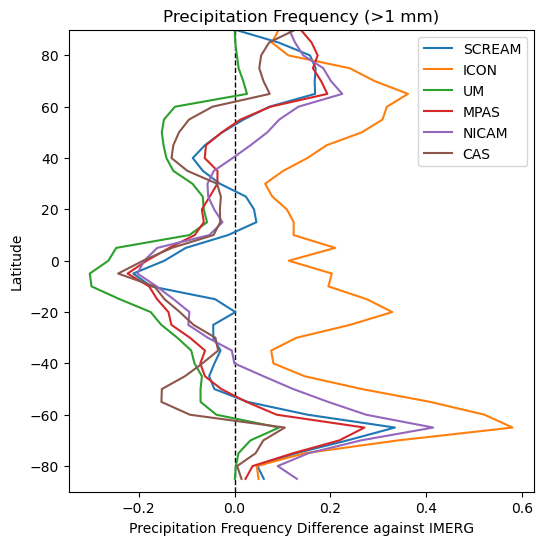

In [27]:

plt.figure(figsize=(6, 6))

plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.plot(frequency_zm_scream - frequency_zm_imerg, frequency_zm_scream.latitudes, label="SCREAM")
plt.plot(frequency_zm_icon - frequency_zm_imerg, frequency_zm_icon.latitudes, label="ICON")
plt.plot(frequency_zm_um - frequency_zm_imerg, frequency_zm_um.latitudes, label="UM")
plt.plot(frequency_zm_mpas - frequency_zm_imerg, frequency_zm_mpas.latitudes, label="MPAS")
plt.plot(frequency_zm_nicam - frequency_zm_imerg, frequency_zm_nicam.latitudes, label="NICAM")
plt.plot(frequency_zm_cas - frequency_zm_imerg, frequency_zm_cas.latitudes, label="CAS")

# plt.xlim(0, 1)
plt.ylim(-90, 90)

plt.xlabel("Precipitation Frequency Difference against IMERG")
plt.ylabel("Latitude")
plt.title("Precipitation Frequency (>1 mm)")
plt.legend()


In [18]:
# cluster.close()